In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

from tqdm import tqdm

In [2]:
from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter, get_all_sqz_input, KAN_es

In [3]:
SCRIPT_DIR = os.path.abspath('')

## Loading data

In [4]:
d_config = JSON_Read("", "json_config.txt")

EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = 'NO3'#d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE'] # For KAN

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']
MAX_ITER = d_config['MAX_ITER'] # Upper bound of number of iterationd. For MLP
TOL = d_config['TOL']

d_config

{'SPEC_FOLDER': 'full_data',
 'EXCITE_WAVE_LENGTH': 350,
 'PREDICT_IONS': ['Cr'],
 'TRAIN_TEST_RATIO': 0.9,
 'VALIDATION_TRAIN_RATIO': 0.222,
 'RANDOM_STATE_SPLIT': 42,
 'N_ITER_NO_CHANGE': 100,
 'HIDDEN_LAYER_SIZES': 64,
 'RANDOM_STATE_TRAIN': 42,
 'ACTIVATION': 'tanh',
 'SOLVER': 'adam',
 'EARLY_STOPPING': True,
 'MAX_ITER': 10000,
 'TOL': 0.001}

In [5]:
x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

In [6]:
y

array([ 0.  ,  1.65,  3.3 ,  4.95,  6.6 ,  8.25,  9.9 , 11.55, 13.2 ,
       14.85,  1.1 ,  2.75,  4.4 ,  6.05,  7.7 ,  9.35, 11.  , 12.65,
       14.3 , 15.95,  2.2 ,  3.85,  5.5 ,  7.15,  8.8 , 10.45, 12.1 ,
       13.75, 15.4 , 17.05,  3.3 ,  4.95,  6.6 ,  8.25,  9.9 , 11.55,
       13.2 , 14.85, 16.5 , 18.15,  4.4 ,  6.05,  7.7 ,  9.35, 11.  ,
       12.65, 14.3 , 15.95, 17.6 , 19.25,  5.5 ,  7.15,  8.8 , 10.45,
       12.1 , 13.75, 15.4 , 17.05, 18.7 , 20.35,  6.6 ,  8.25,  9.9 ,
       11.55, 13.2 , 14.85, 16.5 , 18.15, 19.8 , 21.45,  7.7 ,  9.35,
       11.  , 12.65, 14.3 , 15.95, 17.6 , 19.25, 20.9 , 22.55,  8.8 ,
       10.45, 12.1 , 13.75, 15.4 , 17.05, 18.7 , 20.35, 22.  , 23.65,
        9.9 , 11.55, 13.2 , 14.85, 16.5 , 18.15, 19.8 , 21.45, 23.1 ,
       24.75,  1.1 ,  2.75,  4.4 ,  6.05,  7.7 ,  9.35, 11.  , 12.65,
       14.3 , 15.95,  2.2 ,  3.85,  5.5 ,  7.15,  8.8 , 10.45, 12.1 ,
       13.75, 15.4 , 17.05,  3.3 ,  4.95,  6.6 ,  8.25,  9.9 , 11.55,
       13.2 , 14.85,

# Squeeze input data

In [7]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)

In [8]:
x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()

x_sqz = get_all_sqz_input(x_matrix, y_matrix)

In [9]:
def alg_KAN_es(x, y, seed = None, num_hn=1,
               K=3, GRID = 3,
               lamb=0., lamb_l1=1., lamb_entropy=2.,
               steps=200, tol=0.001, n_iter_no_change=10):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        train_size=TRAIN_TEST_RATIO,
                                                        random_state=seed)

    x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, 
                                                      train_size=VALIDATION_TRAIN_RATIO, 
                                                      random_state=seed)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    tc_x_train = torch.from_numpy(x_train)
    tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
    tc_x_val = torch.from_numpy(x_val)
    tc_y_val = torch.from_numpy(y_val).reshape([-1,1])
    tc_x_test = torch.from_numpy(x_test)
    tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

    dataset_3 = {'train_input': tc_x_train,
                 'train_label': tc_y_train,
                 'val_input': tc_x_val,
                 'val_label': tc_y_val,
                 'test_input': tc_x_test,
                 'test_label': tc_y_test}
    
    INPUT_SHAPE = tc_x_test.shape[1]

    model_es = KAN_es(width=[INPUT_SHAPE, num_hn, 1], grid=GRID, k=K, seed=seed)
    result_es = model_es.train_es(dataset_3, 
                                  tol=tol, 
                                  n_iter_no_change=n_iter_no_change,
                                  opt="LBFGS", steps=steps, 
                                  lamb=lamb,
                                  lamb_l1=lamb_l1,
                                  lamb_entropy=lamb_entropy
                                  )
    
    pred_test = model_es(dataset_3['test_input']).cpu().detach().numpy().ravel()
    rmse = mean_squared_error(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)

    return [rmse, r2, mae]

In [10]:
def alg_skl_model(x, y, class_model, model_kwargs, seed = None):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        train_size=TRAIN_TEST_RATIO,
                                                        random_state=seed)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    #print(model_kwargs)
    model = class_model(random_state=seed, **model_kwargs)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    rmse = mean_squared_error(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)

    return [rmse, r2, mae]

In [11]:
MLP_model_kwargs = {'hidden_layer_sizes': HIDDEN_LAYER_SIZES,
                  'activation': ACTIVATION,
                  'solver': SOLVER,
                  'early_stopping': True,
                  'validation_fraction': VALIDATION_TRAIN_RATIO,
                  'n_iter_no_change': N_ITER_NO_CHANGE,
                  'learning_rate_init': 0.001,
                  'learning_rate': 'adaptive',
                  'max_iter': MAX_ITER,
                  'tol': TOL}

GB_model_kwargs = {'validation_fraction': VALIDATION_TRAIN_RATIO,
                   'n_iter_no_change': N_ITER_NO_CHANGE}

RF_model_kwargs = {}

In [12]:
MLP_model_kwargs

{'hidden_layer_sizes': 64,
 'activation': 'tanh',
 'solver': 'adam',
 'early_stopping': True,
 'validation_fraction': 0.222,
 'n_iter_no_change': 100,
 'learning_rate_init': 0.001,
 'learning_rate': 'adaptive',
 'max_iter': 10000,
 'tol': 0.001}

# ---Debugging---

In [13]:
def scatter_prediction(model, 
                       x, 
                       y_true, 
                       title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

In [14]:
def alg_skl_model_dbg(x, y, class_model, model_kwargs, seed = None):

    print('x shape:', x.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        train_size=TRAIN_TEST_RATIO,
                                                        random_state=seed)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    #print(model_kwargs)
    model = class_model(random_state=seed, **model_kwargs)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    rmse = mean_squared_error(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)

    scatter_prediction(model, x_train, y_train, 'train')
    scatter_prediction(model, x_test, y_test, 'test')

    print(model.get_params())
    #print(model.get_metadata_routing())

    return [rmse, r2, mae]

x shape: (1000, 5)


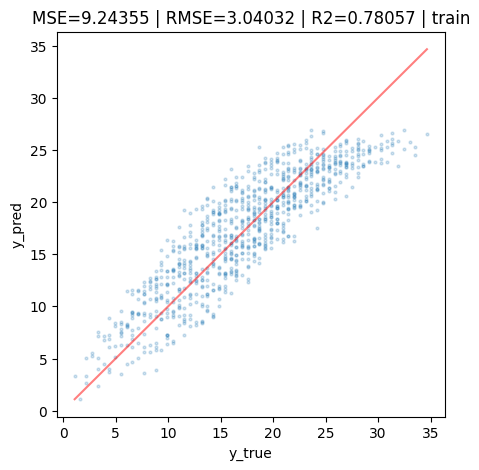

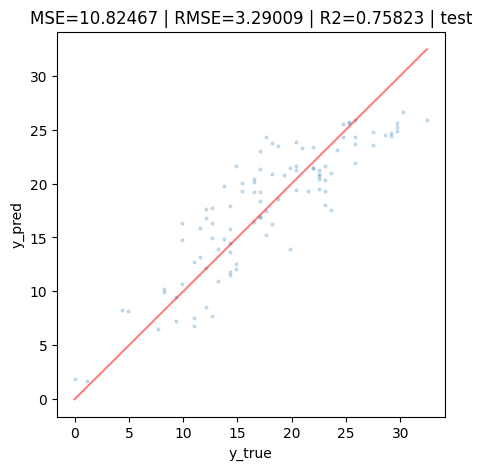

{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 10000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.001, 'validation_fraction': 0.222, 'verbose': False, 'warm_start': False}


[10.824671447529306, 0.7582316427916022, 2.7303600035658]

In [15]:
alg_skl_model_dbg(x_sqz, y, MLPRegressor, MLP_model_kwargs)

# ------

In [16]:
def multi_exp(l_algos_names,
              l_algos,
              mult_X_Y,
              l_kwargs,
              l_metrics_names,
              num_iter):
    ''' Function, that process algos(X, Y) and returns df of their metrics. 
    '''
    res_list = []

    for alg, (x, y), kwargs, alg_name in zip(l_algos, mult_X_Y, l_kwargs, l_algos_names):
        print(f'--- Processing {alg_name}')

        for i in range(1, num_iter+1):
            print(f'iter: {i}')
            #print(kwargs)
            l_metrics = alg(x, y, seed=i, **kwargs)
            res_list.append([alg_name, i]+l_metrics)
        print('-------')

    return pd.DataFrame(res_list, columns=['alg_name', 'iter']+l_metrics_names)

#### Full start: KAN, MLP, RF, GB

In [17]:
l_algos_names=['500_KAN', '500_MLP', '500_RF', '500_GB',
               '5_KAN', '5_MLP', '5_RF', '5_GB']

l_algos=[alg_KAN_es, alg_skl_model, alg_skl_model, alg_skl_model,
         alg_KAN_es, alg_skl_model, alg_skl_model, alg_skl_model]

mult_X_Y=[(x, y), (x, y), (x, y), (x, y), 
          (x_sqz, y), (x_sqz, y), (x_sqz, y), (x_sqz, y)]

l_kwargs=[{},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},
          {},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=100

#### Full start except KAN: MLP, RF, GB

In [18]:
'''
l_algos_names=['500_MLP', '500_RF', '500_GB',
               '5_MLP', '5_RF', '5_GB']

l_algos=[alg_skl_model, alg_skl_model, alg_skl_model,
         alg_skl_model, alg_skl_model, alg_skl_model]

mult_X_Y=[(x, y), (x, y), (x, y), 
          (x_sqz, y), (x_sqz, y), (x_sqz, y)]

l_kwargs=[{'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=3
'''

"\nl_algos_names=['500_MLP', '500_RF', '500_GB',\n               '5_MLP', '5_RF', '5_GB']\n\nl_algos=[alg_skl_model, alg_skl_model, alg_skl_model,\n         alg_skl_model, alg_skl_model, alg_skl_model]\n\nmult_X_Y=[(x, y), (x, y), (x, y), \n          (x_sqz, y), (x_sqz, y), (x_sqz, y)]\n\nl_kwargs=[{'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},\n          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},\n          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},\n          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},\n          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},\n          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},]\n\nl_metrics_names=['rmse', 'r2', 'mae']\n\nnum_iter=3\n"

#### Just MLP

In [19]:
l_algos_names=['500_MLP',
               '5_MLP']

l_algos=[alg_skl_model,
         alg_skl_model]

mult_X_Y=[(x, y), 
          (x_sqz, y)]

l_kwargs=[{'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs}]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=100

#### KAN with different number of neurons in hidden layer: 2, 5

In [20]:
l_algos_names=['500_KAN_2hn','500_KAN_5hn',
               '5_KAN_2hn','5_KAN_5hn']

l_algos=[alg_KAN_es, alg_KAN_es,
         alg_KAN_es, alg_KAN_es]

mult_X_Y=[(x, y), (x, y),
          (x_sqz, y), (x_sqz, y)]

l_kwargs=[{'num_hn': 2}, {'num_hn': 5},
          {'num_hn': 2}, {'num_hn': 5}]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=100

#### MLP with 500 input values with extended n_iter_no_change: 100-->500

In [21]:
MLP_model_kwargs_1 = {'hidden_layer_sizes': HIDDEN_LAYER_SIZES,
                  'activation': ACTIVATION,
                  'solver': SOLVER,
                  'early_stopping': True,
                  'validation_fraction': VALIDATION_TRAIN_RATIO,
                  'n_iter_no_change': 500,#N_ITER_NO_CHANGE,
                  'learning_rate_init': 0.01,
                  'learning_rate': 'adaptive',
                  'max_iter': 100000,#MAX_ITER,
                  'tol': TOL}

l_algos_names=['500_MLP']

l_algos=[alg_skl_model]

mult_X_Y=[(x, y)]

l_kwargs=[{'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs_1}]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=100

In [22]:
full_df = multi_exp(l_algos_names=l_algos_names,
                    l_algos=l_algos,
                    mult_X_Y=mult_X_Y,
                    l_kwargs=l_kwargs,
                    l_metrics_names=l_metrics_names,
                    num_iter=num_iter)

--- Processing 500_MLP
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99
iter: 100
-------


In [23]:
full_df

,alg_name,iter,rmse,r2,mae
0,500_MLP,1,43.688098,-0.285689,5.221067
1,500_MLP,2,41.528050,-0.023961,5.249898
2,500_MLP,3,44.974795,-0.174931,5.250698
3,500_MLP,4,58.048237,-0.476797,6.063438
4,500_MLP,5,47.828951,-0.101778,5.460061
...,...,...,...,...,...
95,500_MLP,96,86.105625,-0.856170,7.373743
96,500_MLP,97,47.155839,-0.019086,5.439292
97,500_MLP,98,33.333461,0.240746,4.586515
98,500_MLP,99,49.154776,-0.203005,5.424585


In [24]:
full_df.to_excel(f'full_metrics_{PREDICT_IONS}_500_MLP_new.xlsx')
#pd.read_excel('full_metrics.xlsx').drop('Unnamed: 0', axis=1)

In [25]:
aggr_df = full_df.groupby(['alg_name']).agg(["mean", "std"]).drop(['iter'], axis=1)
aggr_df.to_excel(f'aggr_metrics_{PREDICT_IONS}_500_MLP_new.xlsx')
aggr_df

rmse                  r2                 mae         
               mean       std      mean       std      mean      std
alg_name                                                            
500_MLP   42.831153  8.904487 -0.010163  0.222801  5.136172  0.53102